In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import os
import re
from statistics import mean
from pathlib import Path
from typing import Tuple

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

_PRNG = np.random.RandomState(0)

# Debug, for minimizing GridSearchCV and RandomizedSearchCV search space
_DEBUG_SEARCH = True

In [2]:
_DATA_DIR = "./data"
_FILE_PROCESSED_DATASET = "processed/lendingclub_2016-2018_processed.csv"
_FILE_PATH_PROCESSED_DATASET = Path(_DATA_DIR + "/" + _FILE_PROCESSED_DATASET)

_IS_PROCESSED_DATASET = False

df = None
# Read in the data, check if a preprocessed dataset exists
if _FILE_PATH_PROCESSED_DATASET.is_file():
    print("Preprocessed dataset found, reading preprocessed dataset")
    _IS_PROCESSED_DATASET = True
    df = pd.read_csv(_FILE_PATH_PROCESSED_DATASET)
else:
    # Read all data
    print("Preprocessed dataset not found, reading all data")
    _dataset_loan_columns = ["loan_amnt",
                             "int_rate",
                             "term",
                             "grade",
                             "sub_grade",
                             "installment",
                             "annual_inc",
                             "loan_status",
                             "verification_status",
                             "purpose"]

    dataset_loans = {}
    for file_name in os.listdir(_DATA_DIR):
        if file_name.endswith(".csv"):
            full_file_path = _DATA_DIR + "/" + file_name
            print(full_file_path)
            loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
            dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]
    
    # Combine all the data into a single dataframe
    print("Combining all the data into a single dataframe")
    for k, dataset in dataset_loans.items():
        if df is None:
            df = dataset
            continue
        df = df.append(dataset, ignore_index=True)

    del dataset_loans
        
    # Convert column types
    print("Converting column types")
    df["loan_amnt"] = df["loan_amnt"].astype(int)
    df["annual_inc"] = df["annual_inc"].astype(int)
    df["int_rate"] = df["int_rate"].apply(lambda int_rate: float(int_rate[:-1]))
    df["term"] = df["term"].apply(lambda term: int(re.search(r'\d+', term).group(0)))
    
    # Remove outliers
    # Annual income must be greater than 0 and less than 1 million
    # Assume 0 is an outlier
    # Assume millioniare+ are outliers
    print("Removing outliers")
    df = df.loc[(df["annual_inc"] > 0) & (df["annual_inc"] < 1000000)]
    
    # Convert non-ordinal, categorical variables to binary vectors
    print("Convert non-ordinal categorical variables to binary vectors (this can take a while)")
    total_columns_to_process = len(df["verification_status"].unique()) + len(df["purpose"].unique())
    columns_processed = 0
    for verification_status in df["verification_status"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", verification_status)
        df["vs_" + verification_status] = df.apply(lambda row: int(row["verification_status"] == verification_status), axis=1)
    for purpose in df["purpose"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", purpose)
        df["p_" + purpose] = df.apply(lambda row: int(row["purpose"] == purpose), axis=1)

    df.drop(columns=["verification_status"], inplace=True)
    df.drop(columns=["purpose"], inplace=True)
    
    # Save processed dataset for future use
    print("Saving processed dataset")
    df.to_csv(_FILE_PATH_PROCESSED_DATASET, index=False, header=True)
    
print("Done!")

Preprocessed dataset found, reading preprocessed dataset
Done!


In [3]:
print("Number of loans in combined dataset:", len(df))
df.head(5)

Number of loans in combined dataset: 1371066


,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,5000,17.27,36,D,D2,178.94,62000,Fully Paid,1,0,...,0,0,0,0,0,0,0,0,0,0
1,22000,6.49,36,A,A2,674.18,134000,Current,0,1,...,0,0,0,0,0,0,0,0,0,0
2,30000,10.75,60,B,B4,648.54,125000,Fully Paid,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10000,16.29,36,D,D1,353.01,40000,Charged Off,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12000,9.75,36,B,B3,385.80,120000,Current,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check if we have any null values
df[df.isnull().any(axis=1)]

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational


### Preprocessing

In [5]:
# Convert ordinal variables to numerical
le_grade = LabelEncoder()
df["grade"] = le_grade.fit_transform(df["grade"])

le_sub_grade = LabelEncoder()
df["sub_grade"] = le_sub_grade.fit_transform(df["sub_grade"])

In [6]:
# Separate the postive/negative class
df_pos = df.loc[df["loan_status"] == "Fully Paid"]
df_neg = df.loc[(df["loan_status"] == "Default") | (df["loan_status"] == "Charged Off")]

In [7]:
df_pos["loan_status"].value_counts()

Fully Paid    382014
Name: loan_status, dtype: int64

In [8]:
df_neg["loan_status"].value_counts()

Charged Off    108758
Default            35
Name: loan_status, dtype: int64

In [9]:
df_pos[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.117732,0.353937,0.114210,0.116027,0.958982,0.422926
int_rate,0.117732,1.000000,0.368597,0.962965,0.987197,0.155487,-0.099715
term,0.353937,0.368597,1.000000,0.357490,0.366070,0.136393,0.079493
grade,0.114210,0.962965,0.357490,1.000000,0.971276,0.148621,-0.099893
sub_grade,0.116027,0.987197,0.366070,0.971276,1.000000,0.151058,-0.108120
installment,0.958982,0.155487,0.136393,0.148621,0.151058,1.000000,0.403238
annual_inc,0.422926,-0.099715,0.079493,-0.099893,-0.108120,0.403238,1.000000


In [10]:
df_neg[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.191178,0.387081,0.187644,0.193173,0.945589,0.450970
int_rate,0.191178,1.000000,0.376418,0.962659,0.983896,0.248679,-0.066134
term,0.387081,0.376418,1.000000,0.372196,0.383811,0.142168,0.109504
grade,0.187644,0.962659,0.372196,1.000000,0.975763,0.238671,-0.068205
sub_grade,0.193173,0.983896,0.383811,0.975763,1.000000,0.244191,-0.070253
installment,0.945589,0.248679,0.142168,0.238671,0.244191,1.000000,0.419332
annual_inc,0.450970,-0.066134,0.109504,-0.068205,-0.070253,0.419332,1.000000


In [11]:
# Take a random even subsample
SUBSAMPLE_AMOUNT = 100000

# The validation set has a similar ratio of pos/neg as the original dataset, ~ 3.5 pos : 1 neg
VALIDATION_POSITIVE_AMOUNT = 28000
VALIDATION_NEGATIVE_AMOUNT = 8000

df_pos = df_pos.sample(n=SUBSAMPLE_AMOUNT + VALIDATION_POSITIVE_AMOUNT, replace=False, random_state=_PRNG)
df_neg = df_neg.sample(n=SUBSAMPLE_AMOUNT + VALIDATION_NEGATIVE_AMOUNT, replace=False, random_state=_PRNG)

df_pos.drop(columns=["loan_status"], inplace=True)
df_neg.drop(columns=["loan_status"], inplace=True)

# Fit scalars
data_to_scale = pd.concat([df_pos, df_neg], ignore_index=True, copy=True).astype(float)
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
minmax_scaler.fit(data_to_scale)
standard_scaler = StandardScaler()
standard_scaler.fit(data_to_scale)
del data_to_scale

# Shuffle before taking our validation set
df_pos = df_pos.sample(frac=1).reset_index(drop=True)
df_neg = df_neg.sample(frac=1).reset_index(drop=True)

# Validation set used later to calculate profitability
df_val_pos = df_pos.tail(VALIDATION_POSITIVE_AMOUNT)
df_val_neg = df_neg.tail(VALIDATION_NEGATIVE_AMOUNT)

df_val_pos.reset_index(drop=True, inplace=True)
df_val_neg.reset_index(drop=True, inplace=True)

df_pos.drop(df_pos.tail(VALIDATION_POSITIVE_AMOUNT).index, inplace=True)
df_neg.drop(df_neg.tail(VALIDATION_NEGATIVE_AMOUNT).index, inplace=True)

print("Subsample pos:", len(df_pos))
print("Subsample neg:", len(df_neg))

Subsample pos: 100000
Subsample neg: 100000


In [12]:
POS_CLASS = 1
NEG_CLASS = 0

# Combine subsamples
df_subsample_X = pd.concat([df_pos, df_neg], ignore_index=True, copy=True)
df_subsample_X = df_subsample_X.astype(float)
df_subsample_Y = [POS_CLASS] * len(df_pos) + [NEG_CLASS] * len(df_neg)

assert len(df_subsample_X) == len(df_subsample_Y), "Dataset and labels must be the same size"

In [13]:
CLASSIFIERS = {}

In [14]:
class ClassifierInfo:
    def __init__(self, classifier, scaler, training_score:float, test_score:float) -> None:
        self.classifier = classifier
        self.scaler = scaler
        self.training_score = training_score
        self.test_score = test_score
    
    def predict(self, row) -> float:
        return self.classifier.predict_proba(self.scaler.transform(row))

### Linear SVM

In [15]:
# Most libraries recommend a hard normalization, mapping the min and max values of a given dimension to [0,1]
# However, a soft normalization is also feasible using StandardScaler
# https://neerajkumar.org/writings/svm/
# https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

scaler = minmax_scaler
# scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [16]:
# Create train/test split
# The training set is much smaller due to computation constraints, SVMs have poor scalability
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, train_size=0.125, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 25000
Training label size: 25000
Test set size: 25000
Test label size: 25000


In [17]:
# Use grid search cross-validation to find the best C, using F1-score
parameters = {
    "C" : [2 ** power for power in range(-5, 9)]
}

if _DEBUG_SEARCH:
    parameters = {
        "C" : [0.0625]
    }

clf = GridSearchCV(SVC(kernel="linear", cache_size=4000, probability=True, random_state=_PRNG), param_grid=parameters, scoring="f1", cv=5, refit=True, n_jobs=-1, verbose=1)
clf.fit(X_train, Y_train)
print (clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


0.6463489756061915 {'C': 0.0625}


SVC(C=0.0625, cache_size=4000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True,
  random_state=<mtrand.RandomState object at 0x000001DE8AAB8AF8>,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
svm = clf.best_estimator_

test_score = svm.score(X_test, Y_test)
test_score

0.63736

In [19]:
CLASSIFIERS["svm"] = ClassifierInfo(classifier=svm, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

In [20]:
for col_name, value in zip(df_pos.columns, svm.coef_.ravel()):
    print("{:20s} : {:.4f}".format(col_name, value))

loan_amnt            : -0.2227
int_rate             : -0.2994
term                 : -0.3696
grade                : -1.4301
sub_grade            : -1.6078
installment          : -0.0151
annual_inc           : 1.3379
vs_Source Verified   : -0.0586
vs_Verified          : -0.2117
vs_Not Verified      : 0.2704
p_credit_card        : 0.0581
p_debt_consolidation : 0.0826
p_small_business     : -0.2185
p_home_improvement   : 0.1093
p_other              : 0.0917
p_major_purchase     : 0.0753
p_vacation           : 0.1250
p_moving             : -0.3255
p_medical            : -0.3393
p_car                : 0.1628
p_house              : 0.1534
p_renewable_energy   : 0.0252
p_wedding            : 0.0000
p_educational        : 0.0000


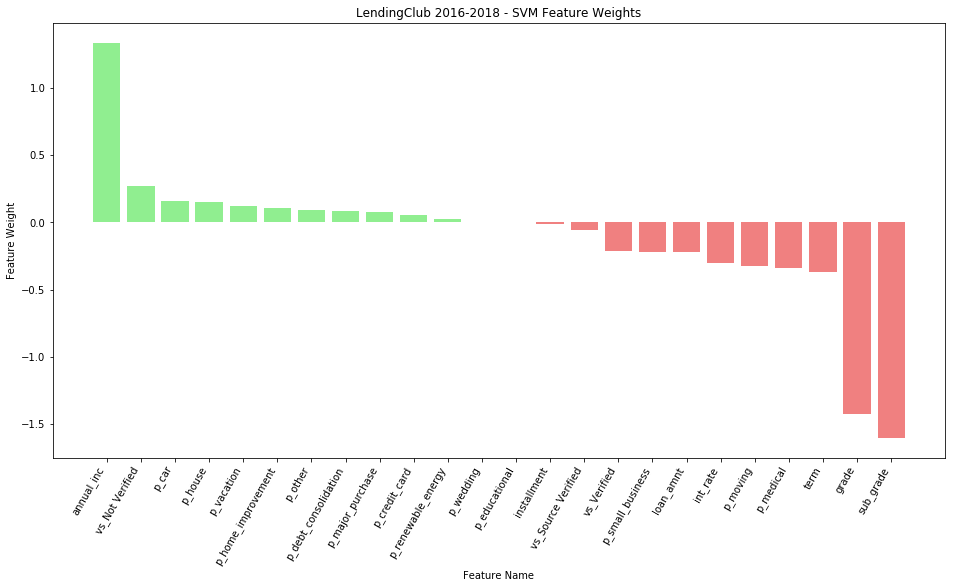

In [21]:
# Plot SVM feature weights
coef = svm.coef_.ravel()
coef_sorted = np.argsort(coef)[::-1]

col = list(df_pos.columns)
colors = ["lightcoral" if feature_weight < 0 else "lightgreen" for feature_weight in coef[coef_sorted]]

plt.figure(figsize=(16, 8))
plt.bar(list(range(len(coef))), coef[coef_sorted], color=colors)
plt.xticks(np.arange(0, len(coef)), [col[idx] for idx in coef_sorted], rotation=60, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Weight")
plt.title("LendingClub 2016-2018 - SVM Feature Weights")
plt.savefig("res/Prediction/SVM - Feature Weights.png", bbox_inches='tight')
plt.show()

### Decision Tree

In [22]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [23]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [24]:
# Use random search to find best hyperparameters
parameters = {
    "max_depth"         : range(1, 31),
    "min_samples_split" : range(2, 21),
    "min_samples_leaf"  : range(1, 11),
    "max_features"      : ["sqrt", "log2", None]
}

if _DEBUG_SEARCH:
    parameters = {
        "max_depth"    : range(10, 11),
        "max_features" : ["sqrt"]
    }

clf = RandomizedSearchCV(DecisionTreeClassifier(criterion="gini", random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)
clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


0.6198271495704906 {'max_features': 'sqrt', 'max_depth': 10}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=<mtrand.RandomState object at 0x000001DE8AB79948>,
            splitter='best')

In [25]:
decision_tree = clf.best_estimator_

test_score =decision_tree.score(X_test, Y_test)
test_score

0.63272

In [26]:
CLASSIFIERS["decision_tree"] = ClassifierInfo(classifier=decision_tree, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

### RandomForest

In [27]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [28]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [29]:
# Use random search to find best hyperparameters
parameters = {
    "n_estimators"      : np.linspace(100, 200, 11),
    "max_depth"         : range(1, 31),
    "min_samples_split" : range(2, 21),
    "min_samples_leaf"  : range(1, 11),
    "max_features"      : ["sqrt", "log2", None]
}

if _DEBUG_SEARCH:
    parameters = {
        "n_estimators"      : range(100, 101),
        "max_depth"         : range(25, 26),
        "min_samples_split" : range(16, 17),
        "min_samples_leaf"  : range(1, 2),
        "max_features"      : ["log2"]
    }

clf = RandomizedSearchCV(RandomForestClassifier(criterion="gini", n_jobs=-1, random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)

clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.8s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s finished


0.6242035001799731 {'n_estimators': 100, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x000001DE8ABD12D0>,
            verbose=0, warm_start=False)

In [30]:
random_forest = clf.best_estimator_

test_score = random_forest.score(X_test, Y_test)
test_score

0.64088

In [31]:
CLASSIFIERS["random_forest"] = ClassifierInfo(classifier=random_forest, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

### Gradient Boosting

In [32]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [33]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [34]:
# Use random search to find best hyperparameters
parameters = {
    "n_estimators"      : np.linspace(100, 200, 11),
    "learning_rate"     : np.arange(.001, .2, 0.002),
    "max_depth"         : range(1, 31),
    "min_samples_split" : range(2, 21),
    "min_samples_leaf"  : range(1, 11),
    "max_depth"         : range(3, 10),
    "max_features"      : ["sqrt", "log2", None]
}

if _DEBUG_SEARCH:
    parameters = {
        "max_features"  : ["sqrt"]
    }

clf = RandomizedSearchCV(GradientBoostingClassifier(loss="deviance", random_state=_PRNG, n_iter_no_change=30, validation_fraction=0.1, tol=1e-4), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)

clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.3s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


0.6284715718581854 {'max_features': 'sqrt'}


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=30, presort='auto',
              random_state=<mtrand.RandomState object at 0x000001DE8AC28630>,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
gradient_boosting = clf.best_estimator_

test_score = gradient_boosting.score(X_test, Y_test)
test_score

0.64788

In [36]:
CLASSIFIERS["gradient_boosting"] = ClassifierInfo(classifier=gradient_boosting, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

### Calculating Profitability

In [37]:
# Calculate annual ROI percent
# If pos class : annual ROI percent = total interest payment / loan amount / loan term (# of years) * 100
# If neg class : annual ROI percent = -1 / loan term (# of years) * 100
def calculate_annual_roi_percent(row) -> float:
    if row["true_class"] == POS_CLASS:
        return ((row["installment"] * row["term"]) - row["loan_amnt"]) / (row["term"] / 12) / row["loan_amnt"] * 100
    
    return -1 / (row["term"] / 12) * 100

# Create dataframe that will be used to calculate profitability
df_predict = pd.concat([df_val_pos, df_val_neg], ignore_index=True, copy=True)

# Create dataframe that will hold profitability results
df_res = df_predict[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].copy(deep=True)
df_res["true_class"] = [1] * len(df_val_pos) + [0] * len(df_val_neg)
df_res["annual_roi_percent"] = df_res.apply(lambda row: calculate_annual_roi_percent(row), axis=1, result_type="reduce")

df_res.tail(5)

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,true_class,annual_roi_percent
35995,10000,16.29,36,3,15,353.01,62458,0,-33.333333
35996,18350,19.53,36,3,19,677.57,41711,0,-33.333333
35997,3025,14.49,36,2,13,104.11,68000,0,-33.333333
35998,6750,21.97,36,4,23,257.69,21120,0,-33.333333
35999,28000,9.44,36,1,5,896.14,28000,0,-33.333333


In [38]:
# Populate classifier scores
df_classifier_scores = pd.DataFrame(columns=[*CLASSIFIERS.keys()])

df_classifier_scores.loc[len(df_classifier_scores)] = [classifier_info.training_score for _, classifier_info in CLASSIFIERS.items()]
df_classifier_scores.loc[len(df_classifier_scores)] = [classifier_info.test_score for _, classifier_info in CLASSIFIERS.items()]
df_classifier_scores.loc[len(df_classifier_scores)] = [classifier_info.classifier.score(df_predict, df_res["true_class"]) for _, classifier_info in CLASSIFIERS.items()]

df_classifier_scores.index = ["train_score_f1", "test_score", "validation_score"]

df_classifier_scores

,svm,decision_tree,random_forest,gradient_boosting
train_score,0.646349,0.619827,0.624204,0.628472
test_score,0.637360,0.632720,0.640880,0.647880
validation_score,0.777611,0.222222,0.580444,0.441556


In [39]:
# Convert dataframe dtype to float to satisfy DataConversionWarning of scalers
for col in df_predict.columns:
    df_predict[col] = df_predict[col].astype(float)

# Calculate classifier predictions on validation data
for classifier, classifier_info in CLASSIFIERS.items():
    df_res[classifier + "_is_pos"] = [pos for neg, pos in classifier_info.predict(df_predict)]
df_res.head(5)

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,true_class,annual_roi_percent,svm_is_pos,decision_tree_is_pos,random_forest_is_pos,gradient_boosting_is_pos
0,8400,12.62,36,2,10,281.50,80000,1,6.880952,0.611372,0.594406,0.565029,0.596223
1,10000,7.35,36,0,3,310.38,48000,1,3.912267,0.694038,0.770211,0.830682,0.760512
2,33925,7.21,36,0,2,1050.77,240000,1,3.834655,0.696098,0.737805,0.815764,0.797210
3,10300,15.59,36,2,14,360.04,25800,1,8.613074,0.447405,0.364587,0.383435,0.339134
4,5000,10.91,36,1,8,163.49,65000,1,5.904267,0.612669,0.606218,0.587660,0.597476


In [40]:
class ClassifierProfitability:
    def __init__(self, classifier_type:str):
        self.type = classifier_type
        self.invested_count = []
        self.invested_pos_percent = []
        self.capital_invested = []
        self.total_return = []
        self.return_on_investment_percent = []
        self.annual_roi_percent = []
        
    def append_values(self, invested_count:float, invested_pos_percent:float, capital_invested:float, total_return:float, return_on_investment_percent:float, annual_roi_percent:float) -> None:
        self.invested_count.append(invested_count)
        self.invested_pos_percent.append(invested_pos_percent)
        self.capital_invested.append(capital_invested)
        self.total_return.append(total_return)
        self.return_on_investment_percent.append(return_on_investment_percent)
        self.annual_roi_percent.append(annual_roi_percent)

# Calculate profitability based on confidence threshold
def calculate_classifier_profitability_on_row(classifier:str, confidence_threshold:float) -> Tuple[float,float,float,float,float]:  
    # Filter by confidence threshold
    df_res_filtered = df_res[df_res[classifier + "_is_pos"] >= confidence_threshold]
    df_res_filtered_pos = df_res_filtered[df_res_filtered["true_class"] == POS_CLASS]
    
    invested_count = len(df_res_filtered)
    
    invested_pos_percent = 0
    if len(df_res_filtered) > 0:
        invested_pos_percent= len(df_res_filtered_pos) / len(df_res_filtered)
#         filtered_pos_percent = len(df_res_filtered_pos) / len(df_res_filtered)
#         population_pos_percent = len(df_val_pos) / len(df_res)
#         invested_pos_percent = (filtered_pos_percent - population_pos_percent) / (1 - population_pos_percent) * 100
    
    capital_invested = sum(df_res_filtered["loan_amnt"])
    
    # Total return = profit + original invested amount
    total_return = sum(df_res_filtered_pos.apply(lambda row: row["installment"] * row["term"], axis=1, result_type="reduce"))
    
    annual_roi_percent = 0
    if len(df_res_filtered) > 0:
        annual_roi_percent = mean(df_res_filtered["annual_roi_percent"])
    
    # Calculate 5 year total ROI, since max loan term is 60 months
    return_on_investment_percent = 0
    if capital_invested > 0:
        return_on_investment_percent = (total_return - capital_invested) / capital_invested * 100
    
    return invested_count, invested_pos_percent, capital_invested, total_return, return_on_investment_percent, annual_roi_percent

# Calculate profitability for all confidence thresholds
def calculate_classifier_profitability(classifier:str, confidence_linspace_num:int):
    classifier_profitability = ClassifierProfitability(classifier)
    
    for confidence_threshold in np.linspace(0, 1, confidence_linspace_num):
        invested_count, invested_pos_percent, capital_invested, total_return, return_on_investment_percent, annual_roi_percent = calculate_classifier_profitability_on_row(classifier, confidence_threshold)
        classifier_profitability.append_values(invested_count, invested_pos_percent, capital_invested, total_return, return_on_investment_percent, annual_roi_percent)
        
    return classifier_profitability

In [41]:
# Calculate profitability for all classifiers
classifier_profitability_list = []

x = np.linspace(0, 1, 101)
for classifier in CLASSIFIERS.keys():
    print(f"Calculating for classifier {classifier}...")
    classifier_profitability_list.append(calculate_classifier_profitability(classifier, len(x)))

print("Done!")

Calculating for classifier svm...
Calculating for classifier decision_tree...
Calculating for classifier random_forest...
Calculating for classifier gradient_boosting...
Done!


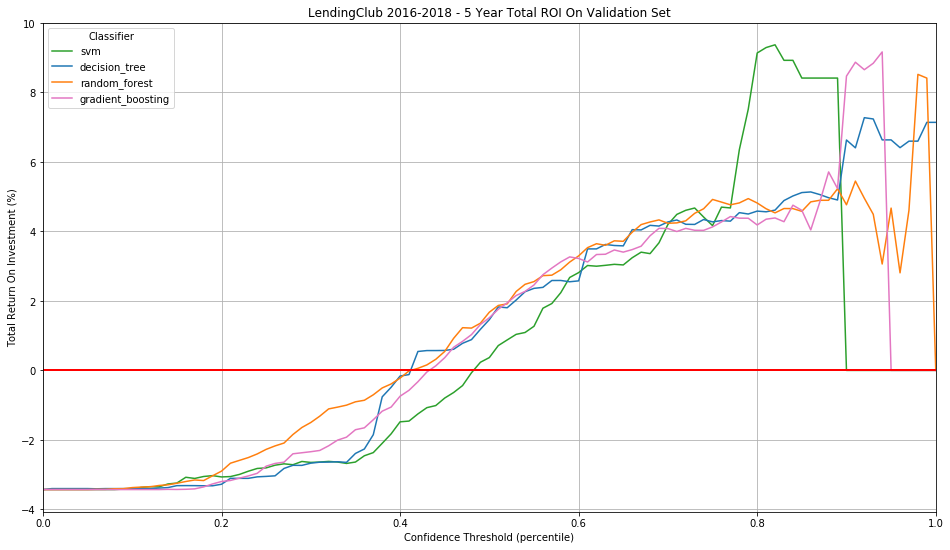

In [42]:
# Line plot of 5 year total ROI on validation set
plt.figure(figsize=(16,9))

colors = {
    "svm"               : "#2ca02c",
    "decision_tree"     : "#1f77b4",
    "random_forest"     : "#ff7f0e",
    "gradient_boosting" : "#e377c2",
}

for classifier_profitability in classifier_profitability_list:
    plt.plot(x, classifier_profitability.return_on_investment_percent, label=classifier_profitability.type, color=colors[classifier_profitability.type])

plt.axhline(0, color='red', linewidth=2)
plt.xlim(left=0, right=1)
plt.grid(True)
plt.xlabel("Confidence Threshold (percentile)")
plt.ylabel("Total Return On Investment (%)")
plt.legend(title="Classifier")
plt.title("LendingClub 2016-2018 - 5 Year Total ROI On Validation Set")
plt.savefig("res/Prediction/LendingClub 2016-2018 - 5 Year Total ROI On Validation Set.png", bbox_inches='tight')
plt.show()

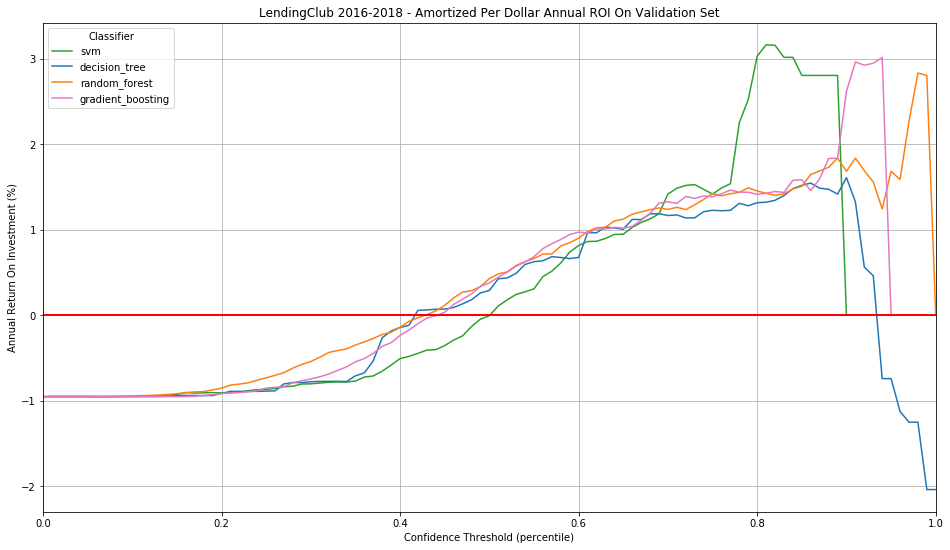

In [43]:
# Line plot of amortized per dollar annual ROI on validation set
plt.figure(figsize=(16,9))

colors = {
    "svm"               : "#2ca02c",
    "decision_tree"     : "#1f77b4",
    "random_forest"     : "#ff7f0e",
    "gradient_boosting" : "#e377c2",
}

for classifier_profitability in classifier_profitability_list:
    plt.plot(x, classifier_profitability.annual_roi_percent, label=classifier_profitability.type, color=colors[classifier_profitability.type])

plt.axhline(0, color='red', linewidth=2)
plt.xlim(left=0, right=1)
plt.grid(True)
plt.xlabel("Confidence Threshold (percentile)")
plt.ylabel("Annual Return On Investment (%)")
plt.legend(title="Classifier")
plt.title("LendingClub 2016-2018 - Amortized Per Dollar Annual ROI On Validation Set")
plt.savefig("res/Prediction/LendingClub 2016-2018 - Amortized Per Dollar Annual ROI On Validation Set.png", bbox_inches='tight')
plt.show()

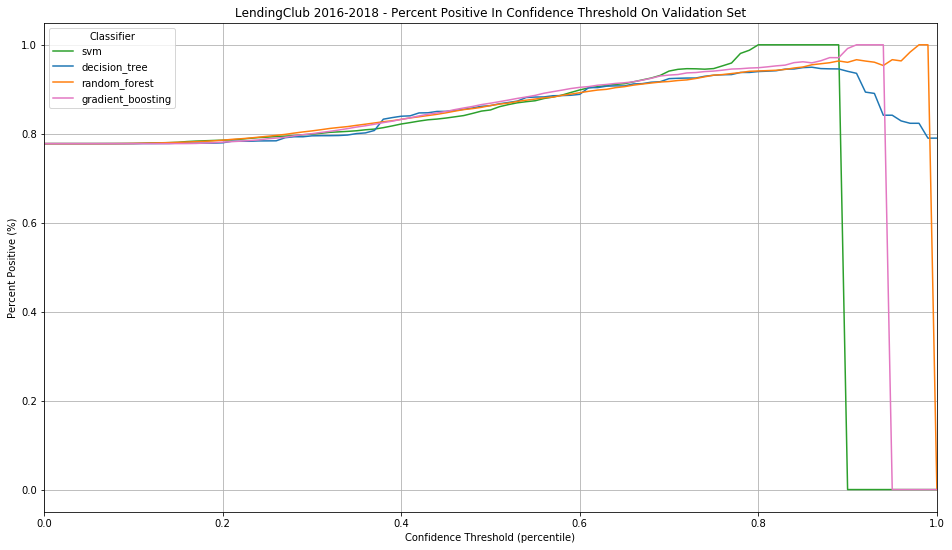

In [47]:
# Line plot of relative alpha on validation set
plt.figure(figsize=(16,9))

colors = {
    "svm"               : "#2ca02c",
    "decision_tree"     : "#1f77b4",
    "random_forest"     : "#ff7f0e",
    "gradient_boosting" : "#e377c2",
}

for classifier_profitability in classifier_profitability_list:
    plt.plot(x, classifier_profitability.invested_pos_percent, label=classifier_profitability.type, color=colors[classifier_profitability.type])

plt.xlim(left=0, right=1)
plt.grid(True)
plt.xlabel("Confidence Threshold (percentile)")
plt.ylabel("Percent Positive (%)")
plt.legend(title="Classifier")
plt.title("LendingClub 2016-2018 - Percent Positive In Confidence Threshold On Validation Set")
plt.savefig("res/Prediction/LendingClub 2016-2018 - Percent Positive In Confidence Threshold On Validation Set.png", bbox_inches='tight')
plt.show()

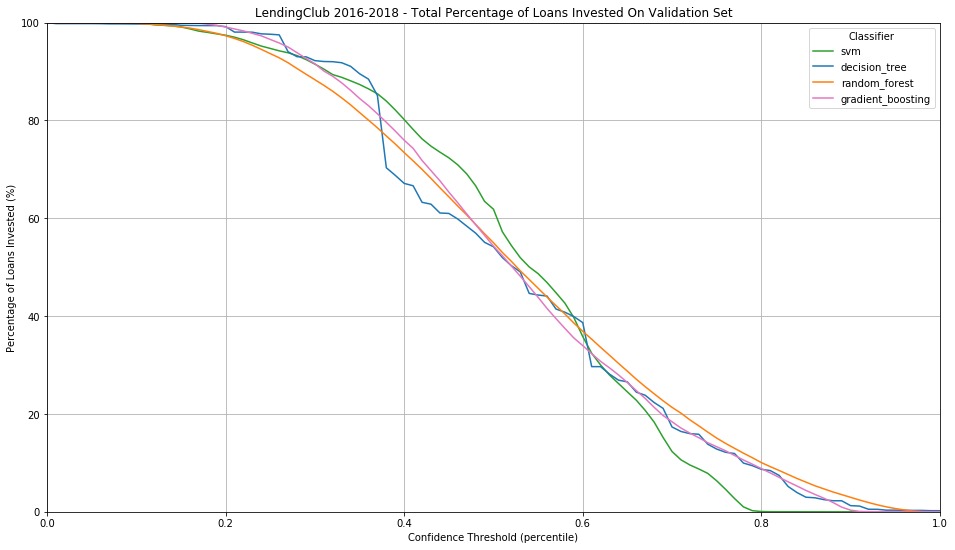

In [45]:
# Line plot of total percentage of loans invested on validation set
plt.figure(figsize=(16,9))

colors = {
    "svm"               : "#2ca02c",
    "decision_tree"     : "#1f77b4",
    "random_forest"     : "#ff7f0e",
    "gradient_boosting" : "#e377c2",
}

for classifier_profitability in classifier_profitability_list:
    invested_percentage_list = [invested_count / len(df_res) * 100 for invested_count in classifier_profitability.invested_count]
    plt.plot(x, invested_percentage_list, label=classifier_profitability.type, color=colors[classifier_profitability.type])

plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=100)
plt.grid(True)
plt.xlabel("Confidence Threshold (percentile)")
plt.ylabel("Percentage of Loans Invested (%)")
plt.legend(title="Classifier")
plt.title("LendingClub 2016-2018 - Total Percentage of Loans Invested On Validation Set")
plt.savefig("res/Prediction/LendingClub 2016-2018 - Total Percentage of Loans Invested On Validation Set.png", bbox_inches='tight')
plt.show()

In [46]:
# classifier = "svm"
# df_res_filtered = df_res[df_res[classifier + "_is_pos"] >= .85]
# df_res_filtered_pos = df_res_filtered[df_res_filtered["true_class"] == POS_CLASS]

# sorted(df_res["svm_is_pos"], reverse=True)